In [1]:
import geopandas as gpd
from pathlib import Path
import numpy as np
import warnings
from tqdm.notebook import tqdm
import datetime
import os
import hvplot.xarray

import networkx as nx
import geonetworkx as gnx

warnings.filterwarnings("ignore")

In [2]:
river_network_fn = Path('../../data-tennessee/rivreg/rivreg.geojson')
river_network_pts_fn = Path('../../data-tennessee/rivreg/rivreg_pts.geojson')
# river_network_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg.geojson')
# river_network_pts_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

DriverError: ../../data-tennessee/rivreg/rivreg.geojson: No such file or directory

{0: Text(-0.24950753623060556, 0.34434405069295176, '0'),
 1: Text(0.275618966107192, -0.039201854208228436, '1'),
 2: Text(0.12757144961637434, 0.015535582299876607, '2'),
 3: Text(0.04490280260197307, -0.03195434884667545, '3'),
 4: Text(-0.060610993194886054, 0.08650771712130453, '4'),
 5: Text(-0.017226768159044958, -0.04120716762558929, '5'),
 6: Text(0.14403326580331635, -0.07787341749611316, '6'),
 7: Text(0.21611599366209122, -0.1368230586162708, '7'),
 8: Text(-0.0028056587527672773, 0.04339772134169108, '8'),
 9: Text(0.18705895302762648, -0.2463934941066045, '9'),
 10: Text(0.12378365094618991, -0.3327988024117555, '10'),
 11: Text(0.19164352323236925, -0.26173476959642333, '11'),
 12: Text(0.2652329554474379, -0.1671244673682278, '12'),
 13: Text(0.25713660488378054, -0.18044036968843363, '13'),
 14: Text(0.28135857431246897, -0.19304017030855278, '14'),
 15: Text(0.2748258813019691, -0.18146496388430094, '15'),
 16: Text(0.3265321603290839, -0.09508219123134952, '16'),
 17

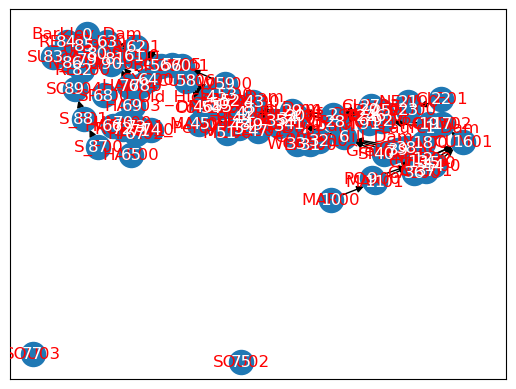

In [ ]:
# quick and simple implementation without landlab

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
# nx.draw(G, nx.drawing.planar_layout(G))
pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [5]:
list(nx.topological_sort(G)) # upstream most is first element

[5,
 9,
 10,
 12,
 14,
 15,
 18,
 19,
 20,
 21,
 22,
 25,
 26,
 27,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 51,
 52,
 53,
 55,
 56,
 57,
 59,
 61,
 64,
 65,
 66,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 82,
 83,
 85,
 87,
 91,
 11,
 1,
 23,
 3,
 7,
 46,
 50,
 54,
 60,
 67,
 84,
 88,
 13,
 24,
 6,
 69,
 89,
 16,
 41,
 76,
 86,
 17,
 81,
 90,
 92,
 2,
 29,
 8,
 4,
 58,
 62,
 63,
 0]

Method:

- Generate topologically sorted list of nodes. This will provide a sequence of nodes with the downstream most node at the end.
- For each Node:
    - Obtain `natural_inflow` from RAT routing results.
    - Obtain `storage_change`. In-situ (for now, later replace with satellite estimates). This will be 0 if node is USGS gage.
    - Get list of upstream nodes.
    - If any upstream nodes, for each upstream node:
        - Obtain **routed** `natural_inflow`.  ; routed = time-lagged
        - Obtain **routed** `outflow`.
    - Calculate `regulated_inflow` = `natural_inflow - sum(upstream_reservoirs['natural_inflow']) + sum(upstream_reservoirs['outflow'])`
    - Calculate `outflow` = `regulated_inflow - `

In [6]:
import xarray as xr
import pandas as pd

In [7]:
RUN_TYPE = 'USGS'

start_date = "2010-01-01"
end_date = "2021-09-30"

rat_output_dir = Path("/water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs")
unregulated_inflow_dir = rat_output_dir / "inflow"
regulation_data_fn = Path("../../data-era5-2010_2021/regulation/regulation_data.insitu.nc")
regulation_data_fn.parent.mkdir(exist_ok=True)
regulation_data_output_fn = regulation_data_fn.with_suffix(f".regulated.{RUN_TYPE}.nc")

insitu_dir = Path("../../data/insitu/")  # observed ∆S, I, O

FileNotFoundError: [Errno 2] No such file or directory: '../../data-era5_2010_2021/tennessee/basins/cumberland/rat_outputs/inflow/Barkl.csv'

# Compile data for running river regulation model and running the model

In [8]:
# Prepare regulation input
# Code to make the regulation_data.nc file.
datasets_to_join = []

for node_id in G:
    node = G.nodes[node_id]
    name = node['name']

    # natural inflow
    unregulated_inflow_fn = unregulated_inflow_dir / f"{name}.csv"
    if not unregulated_inflow_fn.exists():
        print(f"Missing {unregulated_inflow_fn}")
        continue
    unregulated_inflow = pd.read_csv(unregulated_inflow_fn, parse_dates=['date']).rename({
        'date': 'time',
        'inflow (m3/d)': 'unregulated_inflow'
        }, axis='columns')
    # unregulated_inflow['unregulated_inflow'] = unregulated_inflow['unregulated_inflow'] * (24*60*60) # m3/s -> m3/day
    unregulated_inflow['node'] = node_id
    unregulated_inflow.set_index(['time', 'node'], inplace=True)
    unregulated_inflow = unregulated_inflow.to_xarray()
    datasets_to_join.append(unregulated_inflow)

    # # storage change
    # storage_change_fn = storage_change_dir / f"{name}.csv"
    # storage_change = pd.read_csv(storage_change_fn, parse_dates=['date']).rename({
    #     'date': 'time',
    #     'dS (m3)': 'storage_change'
    # }, axis='columns')[['time', 'storage_change']]

    # storage_change['storage_change'] = storage_change['storage_change'] * 1e9 # km3 -> m3
    # # convert storage_change to daily - https://stackoverflow.com/a/73724900
    # storage_change = storage_change.set_index('time')
    # storage_change = storage_change.resample('1D').apply(lambda x: np.nan if x.empty else x)
    # groups = storage_change['storage_change'].notna()[::-1].cumsum()
    # storage_change['storage_change'] = storage_change['storage_change'].fillna(0).groupby(groups).transform('mean')
    # storage_change['node'] = node_id
    # storage_change = storage_change.reset_index().set_index(['time', 'node'])
    # storage_change = storage_change.to_xarray()
    # datasets_to_join.append(storage_change)

    # insitu data
    insitu_fn = insitu_dir / f"{name}.csv"
    insitu = pd.read_csv(insitu_fn, parse_dates=['date']).rename({'date': 'time'}, axis=1)

    insitu['node'] = node_id
    
    # observed inflow
    obs_inflow = insitu[['time', 'node', 'inflow']].rename({'inflow': 'obs_inflow'}, axis=1)
    obs_inflow.set_index(['time', 'node'], inplace=True)
    obs_inflow = obs_inflow.to_xarray() * (24*60*60) # m3/s -> m3/day
    datasets_to_join.append(obs_inflow)

    # observed outflow (if available)
    if 'outflow' in insitu.columns:
        print(f"outflow data available for {name}")
        obs_outflow = insitu[['time', 'node', 'outflow']].rename({'outflow': 'obs_outflow'}, axis=1)
        obs_outflow.set_index(['time', 'node'], inplace=True)
        obs_outflow = obs_outflow.to_xarray() * (24*60*60) # m3/s -> m3/day
        datasets_to_join.append(obs_outflow)
    
    # observed storage change
    obs_storage_change = insitu[['time', 'node', 'storage']].rename({'storage': 'obs_storage_change'}, axis=1)
    obs_storage_change['obs_storage_change'] = obs_storage_change['obs_storage_change'].diff()
    obs_storage_change.set_index(['time', 'node'], inplace=True)
    obs_storage_change = obs_storage_change.to_xarray() * 1e6 # million m3/day -> m3/day
    datasets_to_join.append(obs_storage_change)

# print([type(f) for f in datasets_to_join])
regulation_data = xr.merge(datasets_to_join)
regulation_data.to_netcdf(regulation_data_fn)

Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/POO00.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/MAR00.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/MAR01.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/MAR02.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/CUM00.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/DAV00.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cumberland/final_outputs/inflow/CLE00.csv
Missing /water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/tennessee/basins/cu

Using the dataset generated above, a function can be created in the form of `R(node, time_lag)` that will provide the inflow at a time `t - time_lag`, essentially "routing" the flow based on time-lag routing scheme.

In [9]:
regulation_data_fn

PosixPath('../../data-era5-2010_2021/regulation/regulation_data.insitu.nc')

In [10]:
regulation_data

<xarray.Dataset>
Dimensions:             (time: 30316, node: 9)
Coordinates:
  * time                (time) datetime64[ns] 1938-10-01 ... 2021-09-30
  * node                (node) int64 0 1 2 3 4 5 6 7 8
Data variables:
    unregulated_inflow  (time, node) float64 nan nan nan ... 6.715e+05 8.659e+06
    obs_inflow          (time, node) float64 nan nan nan nan ... nan nan nan nan
    obs_outflow         (time, node) float64 nan nan nan nan ... nan nan nan nan
    obs_storage_change  (time, node) float64 nan nan nan nan ... nan nan nan nan

In [11]:
dt = '1d'

ds = xr.open_dataset(regulation_data_fn)

# add necessary dataarrays
if 'outflow' not in ds.variables:
    ds['outflow'] = xr.full_like(ds['unregulated_inflow'], np.nan)
if 'regulated_inflow' not in ds.variables:
    ds['regulated_inflow'] = xr.full_like(ds['unregulated_inflow'], np.nan)

def upstream_storage_change(ds, nodes, times):
    return 

def update(date, ds, G):
    # (nx.topological_sort(G)) - sort from upstream dams to downstream dams in the network, and iterate over them
    for node in list(nx.topological_sort(G)):
        # get storage change and unregulated inflow for the current reservoir
        storage_change = float(ds['storage_change'].sel(node=node, time=date))
        unregulated_inflow = float(ds['unregulated_inflow'].sel(node=node, time=date))

        # list the upstream reservoirs
        upstreams = list(G.predecessors(node))
        upstream_outflow = 0.0                  # assume 0 outflow from upstream reservoirs (all inflow is due to natural runoff)
        upstream_unregulated_inflow = 0.0
        
        # if there are upstream reservoirs, calculate the total outflow and unregulated inflow from upstream reservoirs
        if len(upstreams) > 0:
            # use time-lag/travel-time that was calculated earlier using Manning's equation
            time_lags = [date - pd.to_timedelta(round(G.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
            upstream_outflow = sum([float(ds['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            upstream_unregulated_inflow = sum([float(ds['unregulated_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
        
        # calculate regulated inflow as unregulated inflow - upstream unregulated inflow + upstream outflow.
        # if the result is negative, set it to 0
        regulated_inflow = max([0, float(unregulated_inflow - upstream_unregulated_inflow + upstream_outflow)])
        # calculate outflow using the regulated inflow
        outflow = max([0, regulated_inflow - storage_change])

        # store the regulated inflow and outflow for the current time-step for later use. move to t+1 and repeat.
        ds['regulated_inflow'].loc[dict(node=node, time=date)] = regulated_inflow
        ds['outflow'].loc[dict(node=node, time=date)] = outflow

dates = pd.date_range(start_date, end_date, freq=dt)#[:10]

with tqdm(total=len(dates)) as pbar:
    for date in dates:
        update(date, ds, G)
        pbar.update(1)
        pbar.set_description(f"{date}")

  0%|          | 0/4291 [00:00<?, ?it/s]

KeyError: 'storage_change'

In [33]:
# save results
ds.to_netcdf(regulation_data_output_fn)
ds.close()

# Read in regulation data for stats calculation

In [2]:
import xarray as xr


# Open regulation data for plotting
# ds = xr.open_dataset(regulation_data_output_fn)
ds = xr.open_dataset("/water2/pdas47/2023_01_24-river-regulation/data-era5-2010_2021/regulation/regulation_data.insitu.obs_outflow.ERA5.nc")
ds

<xarray.Dataset>
Dimensions:                     (node: 9, time: 4018)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-01 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 ...
    outflow                     (node, time) float64 ...
    regulated_runoff            (node, time) float64 ...
    natural_runoff              (node, time) float64 ...
    theoretical_natural_runoff  (time, node) float64 ...
    storage                     (node, time) float64 ...
    storage_change              (time, node) float64 ...
    regulation                  (node, time) float64 ...
    obs_inflow                  (time, node) float64 ...
    obs_outflow                 (time, node) float64 ...

In [4]:
# subset = ds.sel(time=slice(start_date, end_date))
subset = ds
subset

<xarray.Dataset>
Dimensions:                     (node: 9, time: 4018)
Coordinates:
  * node                        (node) int64 0 1 2 3 4 5 6 7 8
  * time                        (time) datetime64[ns] 2010-10-01 ... 2021-09-30
Data variables:
    inflow                      (node, time) float64 ...
    outflow                     (node, time) float64 ...
    regulated_runoff            (node, time) float64 ...
    natural_runoff              (node, time) float64 ...
    theoretical_natural_runoff  (time, node) float64 ...
    storage                     (node, time) float64 ...
    storage_change              (time, node) float64 ...
    regulation                  (node, time) float64 ...
    obs_inflow                  (time, node) float64 ...
    obs_outflow                 (time, node) float64 ...

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import geonetworkx as gnx
from pathlib import Path
import geopandas as gpd
import numpy as np

{0: Text(-1.0, 0.7773163637089667, '0'),
 1: Text(0.7662006020237163, -0.4489390768905482, '1'),
 2: Text(0.42004641595554804, -0.2875615456085062, '2'),
 3: Text(0.0338013584548055, 0.12477509831312913, '3'),
 4: Text(-0.8223197574847505, 0.5881297037338452, '4'),
 5: Text(0.2938442887410629, 0.049654797256947124, '5'),
 6: Text(0.11393708612468036, -0.26646545162398666, '6'),
 7: Text(0.3515784073007357, -0.580597452123878, '7'),
 8: Text(-0.1570884011157999, 0.043687563234031605, '8')}

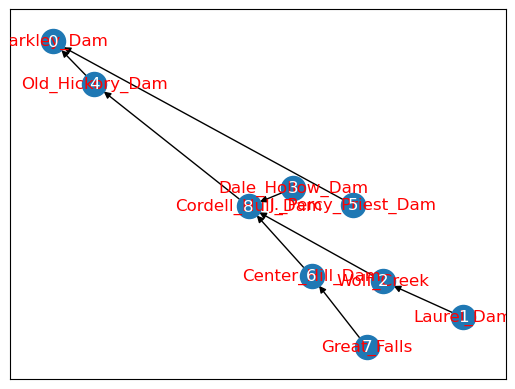

In [21]:
river_network_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg.geojson')
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg/cumberland_rivreg_pts.geojson')
# river_network_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg.geojson')
# river_network_pts_fn = Path('../../data-gunnison/cumberland_rivreg/cumberland_rivreg_pts.geojson')

river_network = gpd.read_file(river_network_fn)
river_network.to_xarray()

river_network_pts = gpd.read_file(river_network_pts_fn)
river_network_pts.to_xarray()

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)

pos = nx.drawing.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [22]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

# Comparison statistics for the entire period

In [37]:
RUN_TYPE = 'ERA5.observed_outflow.2012-2016'
start_date = "2011-10-01"
end_date = "2015-09-30"
subset = subset.sel(time=slice(start_date, end_date))

dims = ['run_type', 'station', 'flow_type']
stat_vars = ['pearson-r', 'pearson-r p-val', 'nse', 'nse1', 'rmse', 'norm_rmse', 'mae', 'norm_mae', 'kge']

results_stats_data = {k: [] for k in dims + stat_vars} # make dictionary to store results

for node in G.nodes:
    station = G.nodes[node]['name']

    # f, ax = plt.subplots(figsize=(12, 6))

    reg_inflow = (subset['inflow'].sel(node=node) * 1e-6)
    nat_inflow = (subset['theoretical_natural_runoff'].sel(node=node) * 1e-6)
    obs_inflow = (subset['obs_inflow'].sel(node=node) * 1e-6)

    no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
        reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['inflow'].data)
    
    no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
    if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
        nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['theoretical_natural_runoff'].data)

    # store results for regulated flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('regulated')
    for var in stat_vars:
        results_stats_data[var].append(reg_inflow_stats[var])

    # store results for natural flow
    results_stats_data['run_type'].append(RUN_TYPE)
    results_stats_data['station'].append(station)
    results_stats_data['flow_type'].append('unregulated')
    for var in stat_vars:
        results_stats_data[var].append(nat_inflow_stats[var])

    # reg_inflow.plot(ax=ax, label=f'Regulated inflow (Mn. m3/day), r:{reg_inflow_stats["pearson-r"]:.2f}, kge:{reg_inflow_stats["kge"]:.4f}, norm_rmse:{reg_inflow_stats["norm_rmse"]:.4f}')
    # nat_inflow.plot(ax=ax, label=f'Natural inflow (from VIC) (Mn. m3/day), r:{nat_inflow_stats["pearson-r"]:.2f}, kge:{nat_inflow_stats["kge"]:.4f}, norm_rmse:{nat_inflow_stats["norm_rmse"]:.4f}', linestyle='dotted')
    # obs_inflow.plot(ax=ax, label=f'Observed inflow (Mn. m3/day)')
    # ax.set_title(f'Station/reservoir: {G.nodes[node]["name"]}. {len(list(G.predecessors(node)))} Upstream dams')
    # ax.set_ylabel("Inflow (Million m3/day)")
    # ax.legend()

    # save_dir = Path("../../results/04_era5")
    # save_dir.mkdir(exist_ok=True)
    # save_fn = save_dir / f"{node:0>2}_{G.nodes[node]['name']}.png"
    # plt.savefig(save_fn)

{'pearson-r': 0.8765490649610531, 'pearson-r p-val': 1.0396026751385591e-233, 'nse': 0.7614556424081009, 'nse1': 0.5797268787517631, 'rmse': 28.77003182635053, 'norm_rmse': 0.10024058098297246, 'mae': 20.818547434271153, 'norm_mae': 0.07253600908851095, 'kge': 0.8449040325504896}
{'pearson-r': 0.7720211251936885, 'pearson-r p-val': 1.264423296580436e-145, 'nse': 0.544642754703223, 'nse1': 0.43310049155477814, 'rmse': 39.74952045937437, 'norm_rmse': 0.1384953290525321, 'mae': 28.081796599266493, 'norm_mae': 0.09784263094133697, 'kge': 0.6977105343236779}
{'pearson-r': 0.5341802009719718, 'pearson-r p-val': 5.0715492852955664e-55, 'nse': 0.2779354242468115, 'nse1': 0.28347284105432224, 'rmse': 1.6541988732135626, 'norm_rmse': 0.08097367375847932, 'mae': 0.8158635010509712, 'norm_mae': 0.03993683349403604, 'kge': 0.28549208993354946}
{'pearson-r': 0.5341802009719718, 'pearson-r p-val': 5.0715492852955664e-55, 'nse': 0.2779354242468115, 'nse1': 0.28347284105432224, 'rmse': 1.65419887321356

In [38]:
import pandas as pd
import datetime

# convert results into dataset
resds = pd.DataFrame(results_stats_data).set_index(dims).to_xarray()

# add attributes
resds['pearson-r'].attrs = {'long_name': 'Pearson correlation coefficient', 'min': -1, 'max': 1, 'unit': '1'}
resds['pearson-r p-val'].attrs = {'long_name': 'Pearson correlation coefficient p-value', 'min': 0, 'max': 1, 'unit': '1'}
resds['nse'].attrs = {'long_name': 'Nash-Sutcliffe efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['nse1'].attrs = {'long_name': 'Nash-Sutcliffe efficiency (NSE1)', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['rmse'].attrs = {'long_name': 'Root mean squared error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_rmse'].attrs = {'long_name': 'Normalized root mean squared error', 'min': 0, 'max': 1, 'unit': '1'}
resds['mae'].attrs = {'long_name': 'Mean absolute error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_mae'].attrs = {'long_name': 'Normalized mean absolute error', 'min': 0, 'max': 1, 'unit': '1'}
resds['kge'].attrs = {'long_name': 'Kling-Gupta efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}

# add coordinate attributes
resds.coords['run_type'].attrs = {'long_name': 'Run type', 'description': 'Type of run to compare between different model runs. For example: `ERA5`, `IMERG-Late`, `IMERG-Final` etc. denoting which type of precipitation product used.'}
resds.coords['station'].attrs = {'long_name': 'Station/reservoir name', 'description': 'Name of station/reservoir'}
resds.coords['flow_type'].attrs = {'long_name': 'Flow type', 'description': 'Regulated or Natural flow'}

# add dataset attributes
resds.attrs = {
    'description': 'Statistics for inflow at each station/reservoir for the specifed time period.', 
    'date_created': str(datetime.datetime.now())
}

try:
    START_DATE = str(subset['time'].min().values)
    END_DATE = str(subset['time'].max().values)
    resds.attrs['from_date'] = START_DATE
    resds.attrs['to_date'] = END_DATE
except:
    pass

resds

<xarray.Dataset>
Dimensions:          (run_type: 1, station: 9, flow_type: 2)
Coordinates:
  * run_type         (run_type) object 'ERA5.observed_outflow.2012-2016'
  * station          (station) object 'Barkley_Dam' ... 'Wolf_Creek'
  * flow_type        (flow_type) object 'regulated' 'unregulated'
Data variables:
    pearson-r        (run_type, station, flow_type) float64 0.8765 ... 0.5501
    pearson-r p-val  (run_type, station, flow_type) float64 1.04e-233 ... 4.7...
    nse              (run_type, station, flow_type) float64 0.7615 ... 0.2867
    nse1             (run_type, station, flow_type) float64 0.5797 ... 0.3594
    rmse             (run_type, station, flow_type) float64 28.77 ... 29.78
    norm_rmse        (run_type, station, flow_type) float64 0.1002 ... 0.08493
    mae              (run_type, station, flow_type) float64 20.82 ... 14.53
    norm_mae         (run_type, station, flow_type) float64 0.07254 ... 0.04144
    kge              (run_type, station, flow_type) float64 0.8449 ... 0.3361
Attributes:
    description:   Statistics for inflow at each station/reservoir for the sp...
    date_created:  2023-09-27 15:21:38.534011
    from_date:     2011-10-01T00:00:00.000000000
    to_date:       2013-09-30T00:00:00.000000000

In [39]:
# save resulting statistics 
save_dir = Path("../../results/rr_stats")
save_dir.mkdir(exist_ok=True, parents=True)
# nc
save_fp = save_dir / f"{str(RUN_TYPE)}.nc"
resds.to_netcdf(save_fp)
# csv
save_fp = save_dir / f"{str(RUN_TYPE)}.csv"
resds.to_dataframe().to_csv(save_fp)

# Comparison statistics, year partitioned into wet vs. dry seasons

- dry season - low precipitation + snowmelt: Oct - Mar
- wet season - high precipitation + snowmelt: Apr - Sep

In [33]:
start_date = "2010-01-01"
end_date = "2013-09-30"
subset = subset.sel(time=slice(start_date, end_date))

dims = ['run_type', 'station', 'flow_type', 'season']
stat_vars = ['pearson-r', 'pearson-r p-val', 'nse', 'nse1', 'rmse', 'norm_rmse', 'mae', 'norm_mae', 'kge']

results_stats_data = {k: [] for k in dims + stat_vars} # make dictionary to store results
season_months = {
    'dry': lambda month: (month >= 5) | (month <= 12),
    'wet': lambda month: (month >= 1) & (month <= 6)
}
# season_months = {
#     'dry': lambda month: (month >= 10) | (month <= 3),
#     'wet': lambda month: (month >= 4) & (month <= 9)
# }

for node in G.nodes:
    station = G.nodes[node]['name']

    for season in ['wet', 'dry']:
        reg_inflow = (subset['regulated_inflow'].sel(node=node).sel(time=season_months[season](subset['regulated_inflow']['time.month'])) * 1e-6)
        nat_inflow = (subset['natural_inflow'].sel(node=node).sel(time=season_months[season](subset['natural_inflow']['time.month'])) * 1e-6)
        obs_inflow = (subset['obs_inflow'].sel(node=node).sel(time=season_months[season](subset['obs_inflow']['time.month'])) * 1e-6)

        no_nan_reg_obs = xr.merge([reg_inflow, obs_inflow]).dropna(dim="time")
        if no_nan_reg_obs.count('time')['obs_inflow'] > 2:
            reg_inflow_stats = get_stats(no_nan_reg_obs['obs_inflow'].data, no_nan_reg_obs['regulated_inflow'].data)
        
        no_nan_nat_obs = xr.merge([nat_inflow, obs_inflow]).dropna(dim="time")
        if no_nan_nat_obs.count('time')['obs_inflow'] > 2:
            nat_inflow_stats = get_stats(no_nan_nat_obs['obs_inflow'].data, no_nan_nat_obs['natural_inflow'].data)

        # store results for regulated flow
        results_stats_data['run_type'].append(RUN_TYPE)
        results_stats_data['station'].append(station)
        results_stats_data['flow_type'].append('regulated')
        results_stats_data['season'].append(season)
        for var in stat_vars:
            results_stats_data[var].append(reg_inflow_stats[var])

        # store results for natural flow
        results_stats_data['run_type'].append(RUN_TYPE)
        results_stats_data['station'].append(station)
        results_stats_data['flow_type'].append('unregulated')
        results_stats_data['season'].append(season)
        for var in stat_vars:
            results_stats_data[var].append(nat_inflow_stats[var])

KeyError: 'regulated_inflow'

In [93]:
from functools import reduce

season = 'wet'
node = 0
# reg_inflow = (subset['regulated_inflow'].sel(node=node).sel(time=season_months[season](subset['regulated_inflow']['time.month'])) * 1e-6)
# nat_inflow = (subset['natural_inflow'].sel(node=node).sel(time=season_months[season](subset['natural_inflow']['time.month'])) * 1e-6)
# obs_inflow = (subset['obs_inflow'].sel(node=node).sel(time=season_months[season](subset['obs_inflow']['time.month'])) * 1e-6)
reg_inflow = (subset['regulated_inflow'].sel(node=node) * 1e-6)
nat_inflow = (subset['natural_inflow'].sel(node=node) * 1e-6)
obs_inflow = (subset['obs_inflow'].sel(node=node) * 1e-6)

reg_in_hv = reg_inflow.hvplot(label='Regulated')
nat_in_hv = nat_inflow.hvplot(label='Unregulated')
obs_in_hv = obs_inflow.hvplot(label='Observed').opts(color='k')

reg_in_hv * nat_in_hv * obs_in_hv

:Overlay
   .Curve.Regulated   :Curve   [time]   (regulated_inflow)
   .Curve.Unregulated :Curve   [time]   (natural_inflow)
   .Curve.Observed    :Curve   [time]   (obs_inflow)

In [94]:
# convert results into dataset
resds = pd.DataFrame(results_stats_data).set_index(dims).to_xarray()

# add attributes
resds['pearson-r'].attrs = {'long_name': 'Pearson correlation coefficient', 'min': -1, 'max': 1, 'unit': '1'}
resds['pearson-r p-val'].attrs = {'long_name': 'Pearson correlation coefficient p-value', 'min': 0, 'max': 1, 'unit': '1'}
resds['nse'].attrs = {'long_name': 'Nash-Sutcliffe efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['nse1'].attrs = {'long_name': 'Nash-Sutcliffe efficiency (NSE1)', 'min': -np.inf, 'max': 1, 'unit': '1'}
resds['rmse'].attrs = {'long_name': 'Root mean squared error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_rmse'].attrs = {'long_name': 'Normalized root mean squared error', 'min': 0, 'max': 1, 'unit': '1'}
resds['mae'].attrs = {'long_name': 'Mean absolute error', 'min': 0, 'max': np.inf, 'unit': '1'}
resds['norm_mae'].attrs = {'long_name': 'Normalized mean absolute error', 'min': 0, 'max': 1, 'unit': '1'}
resds['kge'].attrs = {'long_name': 'Kling-Gupta efficiency', 'min': -np.inf, 'max': 1, 'unit': '1'}

# add coordinate attributes
resds.coords['run_type'].attrs = {'long_name': 'Run type', 'description': 'Type of run to compare between different model runs. For example: `ERA5`, `IMERG-Late`, `IMERG-Final` etc. denoting which type of precipitation product used.'}
resds.coords['station'].attrs = {'long_name': 'Station/reservoir name', 'description': 'Name of station/reservoir'}
resds.coords['flow_type'].attrs = {'long_name': 'Flow type', 'description': 'Regulated or Natural flow'}
resds.coords['season'].attrs = {'long_name': 'Season', 'description': 'Season of the water year. `wet` = April-September, high runoff due to precipitation/snowmelt or `dry` = October-March, low runoff due to preciptation/snowmelt.'}

# add dataset attributes
resds.attrs = {
    'description': 'Statistics for inflow at each station/reservoir for the specifed time period.', 
    'date_created': str(datetime.datetime.now())
}

try:
    START_DATE = str(subset['time'].min().values)
    END_DATE = str(subset['time'].max().values)
    resds.attrs['from_date'] = START_DATE
    resds.attrs['to_date'] = END_DATE
except:
    pass

resds

<xarray.Dataset>
Dimensions:          (run_type: 1, station: 9, flow_type: 2, season: 2)
Coordinates:
  * run_type         (run_type) object 'IMERG-Final-2010_2021'
  * station          (station) object 'Barkley_Dam' ... 'Wolf_Creek'
  * flow_type        (flow_type) object 'regulated' 'unregulated'
  * season           (season) object 'dry' 'wet'
Data variables:
    pearson-r        (run_type, station, flow_type, season) float64 0.5786 .....
    pearson-r p-val  (run_type, station, flow_type, season) float64 2.085e-32...
    nse              (run_type, station, flow_type, season) float64 0.02958 ....
    nse1             (run_type, station, flow_type, season) float64 0.05444 ....
    rmse             (run_type, station, flow_type, season) float64 67.21 ......
    norm_rmse        (run_type, station, flow_type, season) float64 0.08927 ....
    mae              (run_type, station, flow_type, season) float64 47.08 ......
    norm_mae         (run_type, station, flow_type, season) float64 0.06253 ....
    kge              (run_type, station, flow_type, season) float64 0.4954 .....
Attributes:
    description:   Statistics for inflow at each station/reservoir for the sp...
    date_created:  2023-08-29 17:29:02.069848
    from_date:     2010-01-01T00:00:00.000000000
    to_date:       2021-09-30T00:00:00.000000000

In [80]:
# save resulting statistics 
save_dir = Path("../../results/rr_stats_by_season_2")
save_dir.mkdir(exist_ok=True, parents=True)
# nc
save_fp = save_dir / f"insitu.{str(RUN_TYPE)}.nc"
resds.to_netcdf(save_fp)
# csv
save_fp = save_dir / f"insitu.{str(RUN_TYPE)}.csv"
resds.to_dataframe().to_csv(save_fp)